- shuffle the data to see the random level

### Loading data

C:\Users\teristam\Anaconda3\envs\oeEnv\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\teristam\Anaconda3\envs\oeEnv\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\teristam\Anaconda3\envs\oeEnv\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


Total segment read: 275
(3025, 14)


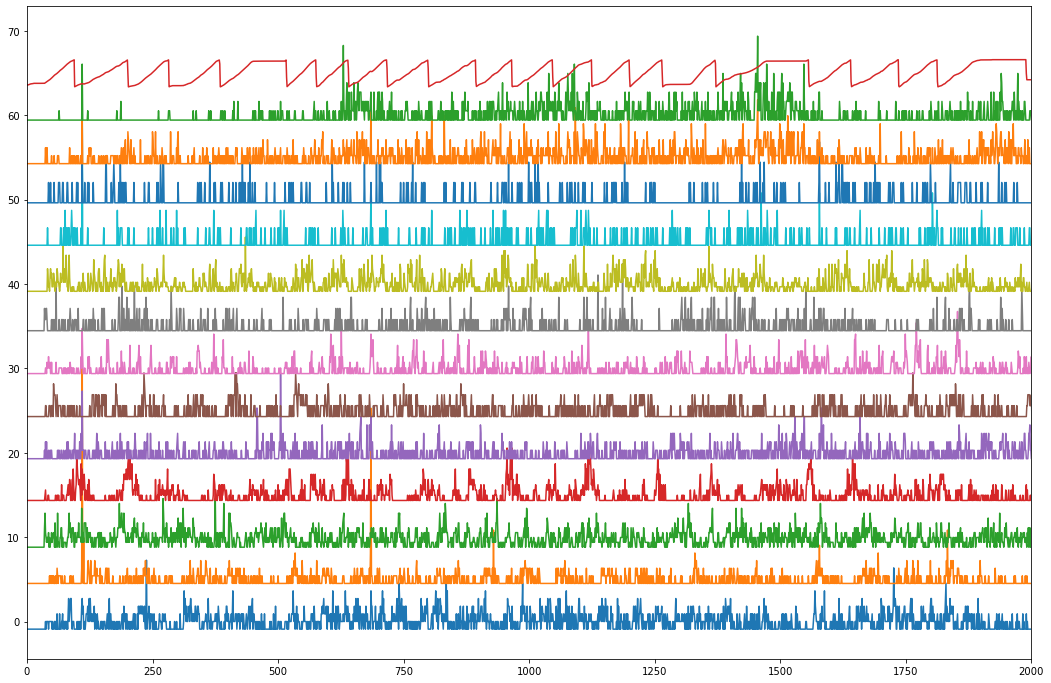

In [1]:
%run 01_load_data.ipynb

### Classification approach
- balanced the data during training

In [4]:
#use a classificaiton approach instead

spk_train = agg_buffer[:,:-1]
pos = agg_buffer[:,-1]

scaler =preprocessing.StandardScaler()
norm_spk_train = scaler.fit_transform(spk_train)

# shuffle data
rand_idx = np.random.permutation(np.arange(norm_spk_train.shape[0]))
norm_spk_train = norm_spk_train[rand_idx,:]

#make sliding window
slidWin = 5
norm_spk_train = makeSlidingWinFeature(norm_spk_train,slidWin)
pos = pos[slidWin-1:]

# bin the position into classes
pos_scaled = preprocessing.minmax_scale(pos,(0,200))
bins = np.arange(0,205,10)
pos_binned = np.digitize(pos_scaled,bins,right=True)
pos_binned[pos_binned==0] = 1 # take care of samples outside bin range

polyFeatures = preprocessing.PolynomialFeatures(1).fit(norm_spk_train)
poly_spiketrain = polyFeatures.transform(norm_spk_train)
# poly_spiketrain= norm_spk_train

# resampler = RandomOverSampler(random_state=0) 
resampler = SMOTE()
classifier = svm.SVC(kernel='rbf',C=1,gamma='auto',probability=True)

val_results = balanced_cross_val_predict(classifier,resampler,poly_spiketrain,pos_binned,scorer=accuracy_score, return_prob=True)
print(val_results.score)

0.06587222773915923


Text(0.5, 69.0, 'Predicted label')

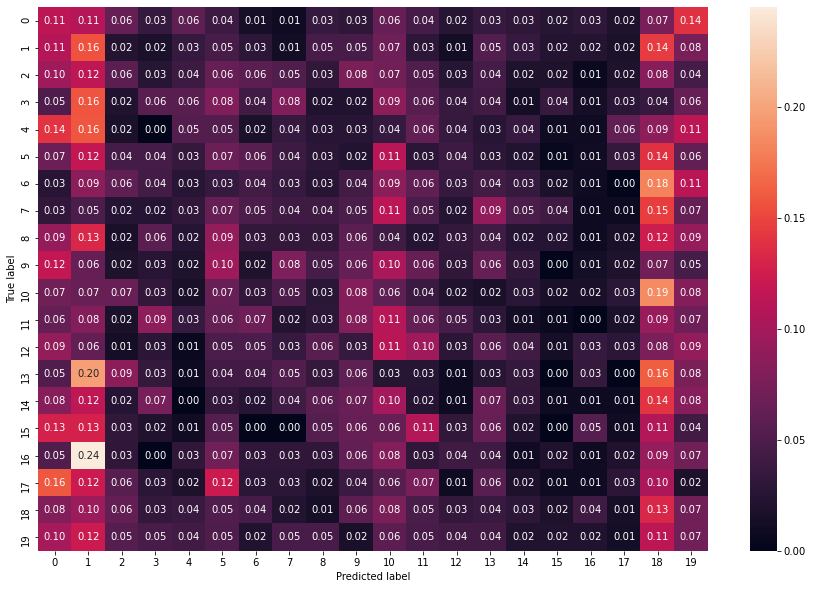

In [5]:
plt.figure(figsize=(15,10))
m = metrics.confusion_matrix(pos_binned,val_results.predicted,normalize='true') #row is true
ax=sns.heatmap(m,annot=True,fmt='.2f')
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')

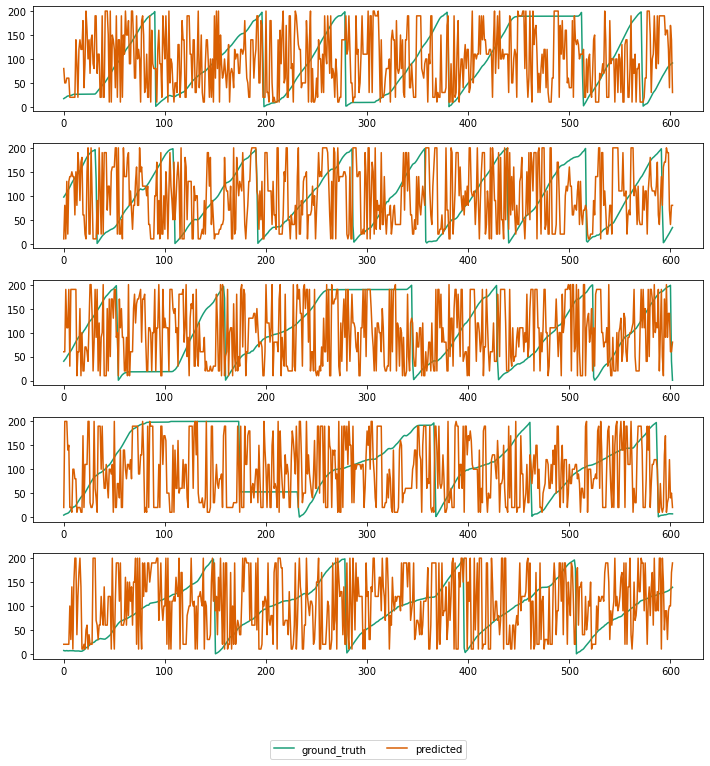

In [6]:
stripplot(pos_scaled,bins[val_results.predicted],figsize=(12,12));

(0.0, 0.5)

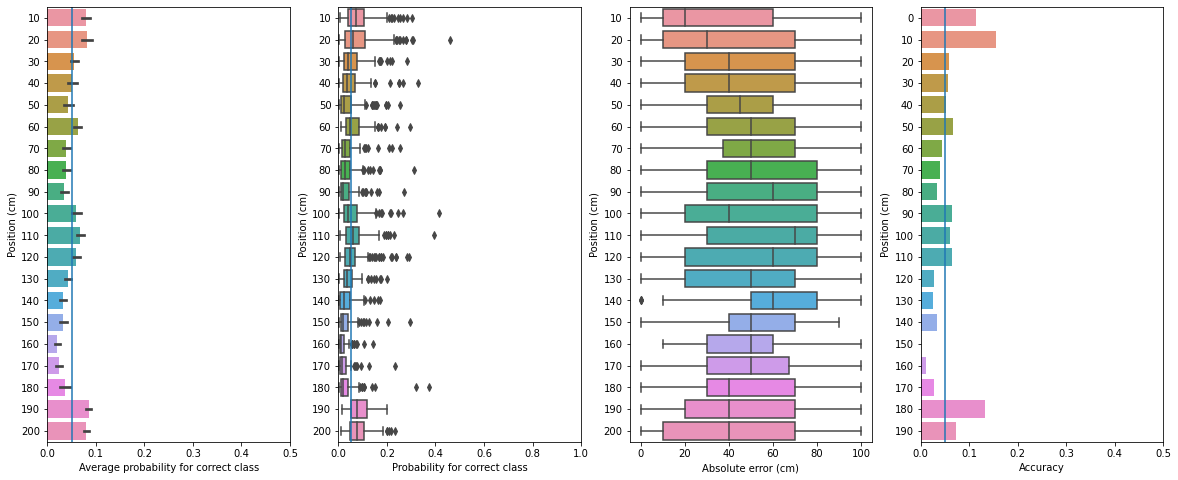

In [12]:
# classification probability vs location
predicted_prob = val_results.predict_prob
predicted_pos = val_results.predicted

true_class_prob = np.take_along_axis(predicted_prob,(pos_binned-1)[:,None],axis=1)
error = np.abs((predicted_pos-pos_binned))*10
error[error>100] = 200 - error[error>100]
#since 200 and 0 are next to each other, so we change the position to an angle
# plot the firing rate in a circle

df_class = pd.DataFrame({'prob':true_class_prob.ravel(), 'pos':(pos_binned)*10, 'error': error})

fig,ax = plt.subplots(1,4,figsize=(20,8))
axIdx = 0
sns.barplot(x='prob',y='pos',orient='h',data=df_class, ax = ax[axIdx])
ax[axIdx].set_xlabel('Average probability for correct class')
ax[axIdx].set_ylabel('Position (cm)');
ax[axIdx].axvline(1/predicted_prob.shape[1])
ax[axIdx].set_xlim([0,0.5])

# fig,ax = plt.subplots(1,1,figsize=(10,8))
axIdx += 1
sns.boxplot(x='prob',y='pos',orient='h',data=df_class, ax = ax[axIdx])
ax[axIdx].set_xlabel('Probability for correct class')
ax[axIdx].set_ylabel('Position (cm)');
ax[axIdx].axvline(1/predicted_prob.shape[1])
ax[axIdx].set_xlim([0,1])

axIdx += 1
sns.boxplot(x='error',y='pos',orient='h',data=df_class, ax = ax[axIdx])
ax[axIdx].set_xlabel('Absolute error (cm)')
ax[axIdx].set_ylabel('Position (cm)');



# accuracy for each position
axIdx +=1
accuracy = []
for i in range(predicted_prob.shape[1]):
    idx = (pos_binned==i+1) #pos_binned is from 1 to 20
    accuracy.append(np.mean(pos_binned[idx] == predicted_pos[idx]))

sns.barplot(y=np.arange(0,200,10),x=accuracy,orient='h',ax=ax[axIdx])
ax[axIdx].set_xlabel('Accuracy')
ax[axIdx].set_ylabel('Position (cm)');
ax[axIdx].axvline(1/predicted_prob.shape[1])
ax[axIdx].set_xlim([0,0.5])

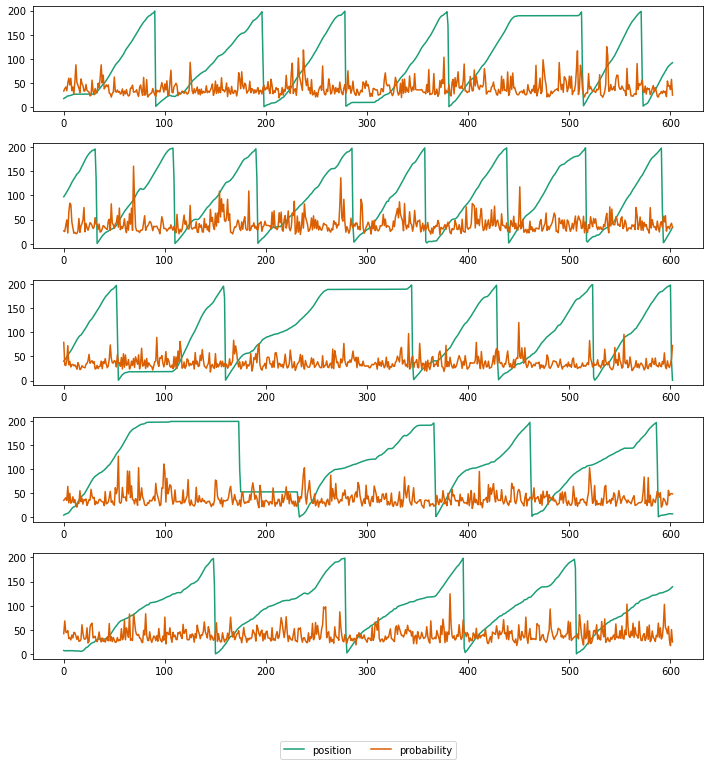

In [13]:
stripplot(pos_scaled,np.max(predicted_prob,axis=1)*200,figsize=(12,12), first_label='position',second_label='probability');
